In [15]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import random as rnd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scorecardpy as sc


In [14]:
pip install scorecardpy

     |████████████████████████████████| 55 kB 382 kB/s eta 0:00:01
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57827 sha256=853c10d53f0d811d6fb565c1534ba706692766a9197d32c69f1546bd72e7a168
  Stored in directory: /Users/alegrettitheo/Library/Caches/pip/wheels/18/b9/40/9fc7fa3ee628a20fb571991f96d54997cfbfab13e752bacd84
Successfully built scorecardpy
Note: you may need to restart the kernel to use updated packages.


On importe nos packages ! 

In [2]:
df=pd.read_csv('/Volumes/ECO/datachallenge/data_finale.csv',sep=',')
df=df.drop(columns=["TOTALAREA_MODE", "LIVINGAREA_AVG"] )

On importe notre base et on retire les variables que l'on utilisera pas. 

[INFO] creating woe binning ...
Le train_size est : 0.75


Shape train_set (16500, 9)
Shape test_set (5500, 9)
Le train_size est : 0.75


Shape train_set (16500, 9)
Shape test_set (5500, 9)
Cette opération peut prendre quelques minutes...

[INFO] converting into woe values ...
[INFO] converting into woe values ...
On va rééchantillonner le train set...

{'k_neighbors': 15, 'n_jobs': None, 'random_state': 0, 'sampling_strategy': 'auto'}


La nouvelle proportion de 0 et 1 de la target resamplée est: Counter({0: 15000, 1: 15000})


0    0.5
1    0.5
Name: TARGET, dtype: float64


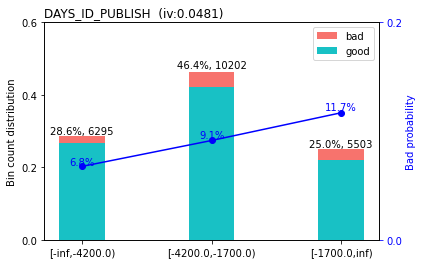

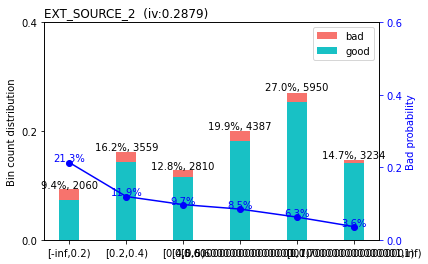

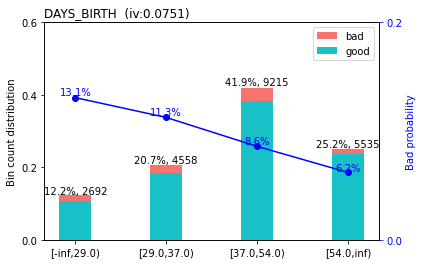

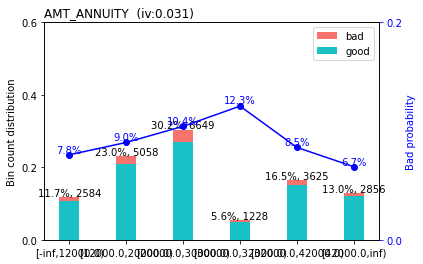

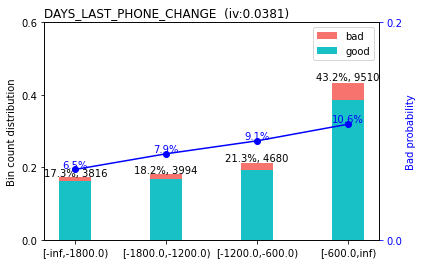

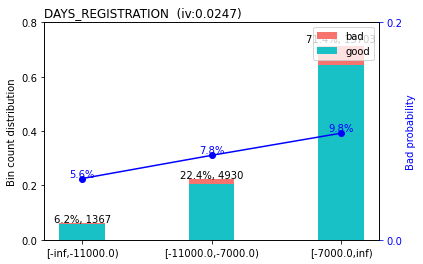

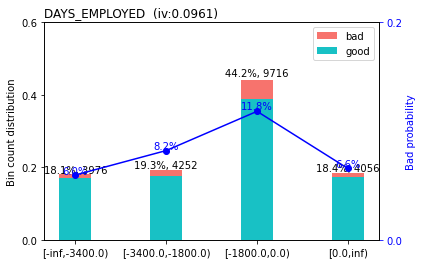

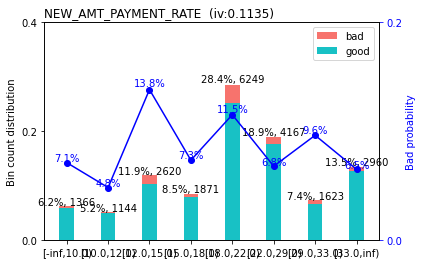

In [23]:
x=df.drop(columns=["TARGET"])
y=df["TARGET"]


def creation_des_classes():    #CREATION DES CLASSES PAR "CHIMERGE"
    classes = sc.woebin(df, y="TARGET", positive=1, method="chimerge")
    return classes
classes=creation_des_classes()

sc.woebin_plot(classes)


def split(train_size):
    train_set, test_set = sc.split_df(df, y="TARGET", ratio=train_size, seed=186).values()
    print('Le train_size est :', train_size)
    
    print("\n")
    print('Shape train_set', train_set.shape)
    print('Shape test_set', test_set.shape)
    return train_set, test_set

train_set, test_set = split(0.75)

def split(train_size):
    train_set, test_set = sc.split_df(df, y="TARGET", ratio=train_size, seed=186).values()
    print('Le train_size est :', train_size)
    
    print("\n")
    print('Shape train_set', train_set.shape)
    print('Shape test_set', test_set.shape)
    return train_set, test_set

train_set, test_set = split(0.75)
#CONVERSION DES CLASSES DES VARIABLES DES TRAIN ET test SETS EN WOE
def conversion_woe():
    print("Cette opération peut prendre quelques minutes...\n")
    train_woe = sc.woebin_ply(train_set, classes)
    test_woe = sc.woebin_ply(test_set, classes)
    
    #CREATION DES X ET y DES TRAIN ET test SETS
    y_train = train_woe.loc[:,"TARGET"]
    x_train = train_woe.loc[:,train_woe.columns != "TARGET"]
    y_test  = test_woe.loc[:,"TARGET"]
    x_test  = test_woe.loc[:,train_woe.columns != "TARGET"]
    
    return y_train, x_train, y_test, x_test, train_woe, test_woe

y_train, x_train, y_test, x_test, train_woe, test_woe=conversion_woe()

def over_sampling():
    
    #ON VA FAIRE DE MANIÈRE AUTO
    print("On va rééchantillonner le train set...\n")
    from imblearn.over_sampling import SMOTE
    
    smote = SMOTE(random_state=0 ,k_neighbors=15)
    x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

    print(smote.get_params(deep=True))
    print("\n")

    from collections import Counter
    print("La nouvelle proportion de 0 et 1 de la target resamplée est: %s" % Counter(y_train_smote))
    print("\n")
    print(y_train_smote.value_counts(normalize=True))
    
    return x_train_smote, y_train_smote

x_train_smote, y_train_smote = over_sampling()


On divise notre base en utilisant un procédé smote pour équilibrer et augmenter artificiellement la taille du training test. Suite à ça, on lance nos modélisations et leurs optimisations : tunning ! Avant cela, nous allons faire de la classification par variable pour comprendre les paramètres d'influences : 

On commence par le modèle Xgboost : 

In [30]:
xgb_clf = xgb.XGBClassifier().fit(x_train_smote, y_train_smote)
xgb_clf.score(x_test, y_test)
xgb_pred = xgb_clf.predict(x_test)
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:02:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[   0 5000]
 [   0  500]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5000
           1       0.09      1.00      0.17       500

    accuracy                           0.09      5500
   macro avg       0.05      0.50      0.08      5500
weighted avg       0.01      0.09      0.02      5500



/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

On présente les différentes métriques dans le powerpoint. On passe au modèle de régression logistique 1 : 

In [24]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_sgdlogreg.fit(x_train_smote, y_train_smote)

grid_sgdlogreg.best_score_
grid_sgdlogreg.best_params_

print(grid_sgdlogreg.best_score_, '- Logistic regression')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.6892333222222222 - Logistic regression


Logistique 2 : 

In [51]:
def modèle():
    #LE MODÈLE FINAL QUI SERA APPLIQUÉ AU TEST SET 
    print("Voici notre meilleur modèle \n")
    m=LogisticRegression(penalty='l2', C=5, solver='saga', max_iter=100, random_state=0).fit(x_train_smote, y_train_smote)

    print("La modèle est :", m)
    print("m.fit(X_train_smote, y_train_smote) \n") 
    
        #PREDICTIONS À PARTIR DU SMOTE
    test_pred_m=m.predict_proba(x_test)[:,1]
    train_pred_m=m.predict_proba(x_train_smote)[:,1]
    test_pred_m_b = test_pred_m>0.5

        #SCORES DU 2E MODÈLE RESAMPLÉ
    train_score_m=m.score(x_train_smote, y_train_smote)
    test_score_m=m.score(x_test, y_test)
    
    print("train score :", train_score_m)
    print("test score :", test_score_m)

    
        #CLASSIFICATION REPORT
    print("\n")
    class_report_m= classification_report(y_test, test_pred_m_b)
    print("classification_report :\n",class_report_m)

    return m,train_pred_m,test_pred_m
m,train_pred_m,test_pred_m=modèle()


Voici notre meilleur modèle 

La modèle est : LogisticRegression(C=5, random_state=0, solver='saga')
m.fit(X_train_smote, y_train_smote) 

train score : 0.6333333333333333
test score : 0.66


classification_report :
               precision    recall  f1-score   support

           0       0.95      0.66      0.78      5000
           1       0.16      0.64      0.26       500

    accuracy                           0.66      5500
   macro avg       0.55      0.65      0.52      5500
weighted avg       0.88      0.66      0.73      5500



On passe au KNN supervised : 

In [25]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

#Tunning
param_grid_knn = {
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_knn.fit(x_train_smote, y_train_smote)

grid_knn.best_score_
grid_knn.best_params_
y_pred_KNN = grid_knn.predict(x_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Random forest : 

In [29]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

grid_rfc.fit(x_train, y_train)
grid_rfc.best_score_
y_pred_RF = grid_rfc.predict(x_test)

print(confusion_matrix(y_test,y_pred_RF))
print(grid_rfc.best_score_, '- Random forest')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[[4862  138]
 [ 479   21]]
0.573429 - Random forest


Calcul des scores de classification : 

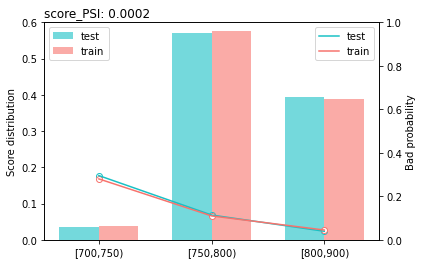

{'psi':   variable       PSI
 0    score  0.000181,
 'pic': {'score': <Figure size 432x288 with 2 Axes>},
 'dat': {'score':           bin     N         badprob          
  ae             test train      test     train
  0   [700,750)   193   607  0.295337  0.280066
  1   [750,800)  3143  9491  0.113904  0.109788
  2   [800,900)  2164  6402  0.039279  0.044986}}

In [46]:
def points_par_classe(base, pdo):
    
    #CREATION DE LA GRILLE SCORE À PARTIR DES CLASSES, DU MODÈLE M ET CALIBRAGE SUR "base" POINTS
    points_par_classe = sc.scorecard(classes, m, xcolumns=x_train.columns, points0=base, pdo=pdo)

    return points_par_classe

points_par_classe=points_par_classe(base=1000, pdo=50)
def scores():

        #CALCUL DES SCORES TOTAUX DANS LE TRAIN SET
    train_score = sc.scorecard_ply(train_set, points_par_classe, print_step=0)
        #CALCUL DES SCORES DANS LE TEST SET
    test_score = sc.scorecard_ply(test_set, points_par_classe, print_step=0)
    
    return train_score, test_score
train_score, test_score=scores()
train_score
#POPULATION STABILITY INDEX (PSI)
sc.perf_psi(score = {'train':train_score, 'test':test_score}, 
        label = {'train':y_train, 'test':y_test},
        return_distr_dat=True)

/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


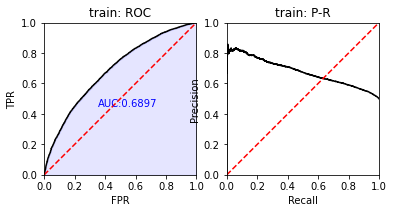

/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


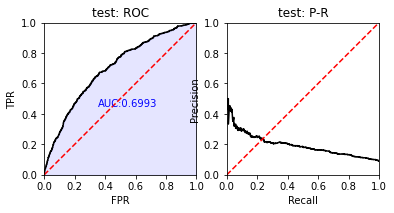

/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


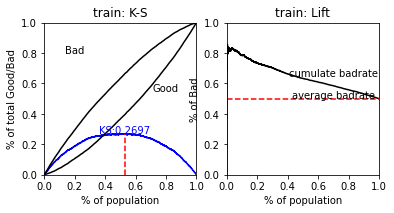

/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/Users/alegrettitheo/opt/anaconda3/envs/work/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


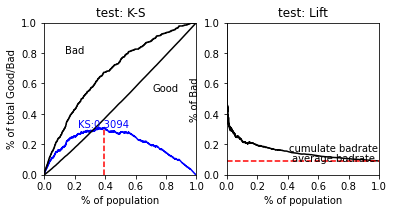

In [54]:
train_perf_ROC = sc.perf_eva(y_train_smote, train_pred_m, title = "train", positive=1, plot_type=["roc", "pr"])
test_perf_ROC  = sc.perf_eva(y_test, test_pred_m, title = "test", positive=1, plot_type=["roc", "pr"])

#KOLMOGOROV - SMIRNOV & Lift
train_perf_KS = sc.perf_eva(y_train_smote, train_pred_m, title = "train", positive=1, plot_type=["ks", "lift"])
test_perf_KS = sc.perf_eva(y_test, test_pred_m, title = "test", positive=1, plot_type=["ks", "lift"])

Et voila, le meilleur modèle reste les KNN, on utilisera ça pour prédire au mieu les cas de fraudes